# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

In [1]:
!wget https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv

--2016-11-07 01:39:13--  https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv
Resolving data.baltimorecity.gov (data.baltimorecity.gov)... 52.206.140.199
Connecting to data.baltimorecity.gov (data.baltimorecity.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [   <=>                ]  32.92M  60.9MB/s   in 0.5s   

Last-modified header invalid -- time-stamp ignored.
2016-11-07 01:39:13 (60.9 MB/s) - ‘rows.csv’ saved [34515653]



## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

In [2]:
!wc -l rows.csv

283615 rows.csv


In [3]:
!shuf -n 10000 rows.csv | csvstat

  1. 02/04/2016
	<class 'datetime.date'>
	Nulls: False
	Min: 2011-01-01
	Max: 2016-10-28
	Unique values: 2104
	5 most frequent values:
		2012-05-01:	16
		2011-12-11:	14
		2012-08-12:	13
		2013-10-25:	13
		2013-11-22:	13
  2. 22:00:00
	<class 'str'>
	Nulls: False
	Unique values: 1286
	5 most frequent values:
		18:00:00:	262
		16:00:00:	241
		12:00:00:	222
		21:00:00:	218
		20:00:00:	215
	Max length: 8
  3. 5A
	<class 'str'>
	Nulls: False
	Unique values: 67
	5 most frequent values:
		4E:	1678
		6D:	1338
		7A:	965
		5A:	942
		6G:	597
	Max length: 4
  4. 2000 W PRATT ST
	<class 'str'>
	Nulls: True
	Unique values: 6218
	5 most frequent values:
		1500 RUSSELL ST:	21
		200 E PRATT ST:	18
		300 LIGHT ST:	16
		1200 W PRATT ST:	16
		3200 TIOGA PW:	15
	Max length: 32
  5. BURGLARY
	<class 'str'>
	Nulls: False
	Unique values: 15
	5 most frequent values:
		LARCENY:	2153
		COMMON ASSAULT:	1678
		BURGLARY:	1554
		LARCENY FROM AUTO:	1338
		AUTO THEFT:	1026
	Max length: 20
  6. I
	<class 'str'>
	Nulls:

In [4]:
!csvcut -n rows.csv

  1: CrimeDate
  2: CrimeTime
  3: CrimeCode
  4: Location
  5: Description
  6: Inside/Outside
  7: Weapon
  8: Post
  9: District
 10: Neighborhood
 11: Location 1
 12: Total Incidents


## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

In [5]:
%load_ext sql
!echo 'redspot' | sudo -S service postgresql restart
!createdb -U dbuser BaltimoreCrime
%sql postgresql://dbuser@localhost:5432/BaltimoreCrime

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


'Connected: dbuser@BaltimoreCrime'

In [6]:
%%sql
DROP TABLE IF EXISTS BaltimoreCrime;
CREATE TABLE BaltimoreCrime (
    CrimeDate TIMESTAMP,
    CrimeTime VARCHAR(64),
    CrimeCode VARCHAR(64),
    Location VARCHAR(64),
    Description VARCHAR(64),
    Inside_Outside VARCHAR(64),
    Weapon VARCHAR(64),
    Post INTEGER,
    District VARCHAR(64),
    Neighborhood VARCHAR(64),
    Location_1 VARCHAR(64),
    Total_Incidents INTEGER
)

Done.
Done.


[]

In [7]:
%%sql
COPY BaltimoreCrime FROM '/home/jovyan/work/rows.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

283614 rows affected.


[]

We used COUNT() to verify that the data was all loaded into the table.

In [8]:
%%sql
SELECT COUNT(*) FROM BaltimoreCrime;

1 rows affected.


count
283614


We checked the first five rows to see that the data formats carried over properly.

In [9]:
%%sql
SELECT *
FROM BaltimoreCrime
LIMIT 5;

5 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents
2016-10-29 00:00:00,00:01:00,6E,4700 FURLEY AVE,LARCENY,O,None,443,NORTHEASTERN,Frankford,"(39.3285900000, -76.5517800000)",1
2016-10-29 00:00:00,00:01:00,7A,3500 LIBERTY HEIGHTS AVE,AUTO THEFT,O,None,642,NORTHWESTERN,Forest Park,"(39.3250400000, -76.6748500000)",1
2016-10-29 00:00:00,00:58:00,6C,0 LIGHT ST,LARCENY,I,None,111,CENTRAL,Downtown,"(39.2884300000, -76.6137200000)",1
2016-10-29 00:00:00,01:00:00,6D,2200 BERLIN ST,LARCENY FROM AUTO,O,None,921,SOUTHERN,Saint Paul,"(39.2695600000, -76.6447300000)",1
2016-10-29 00:00:00,01:00:00,7A,2800 E FEDERAL ST,AUTO THEFT,O,None,332,EASTERN,Berea,"(39.3091700000, -76.5780900000)",1


To make the data easier to explore, we separated the data column into year, month, and day. We also added a unique id called incident_id.

In [10]:
%%sql
ALTER TABLE BaltimoreCrime
ADD COLUMN incident_id SERIAL;

Done.


[]

In [11]:
%%sql
ALTER TABLE BaltimoreCrime
ADD COLUMN year NUMERIC;

Done.


[]

In [12]:
%%sql
ALTER TABLE BaltimoreCrime
ADD COLUMN month NUMERIC;

Done.


[]

In [13]:
%%sql
ALTER TABLE BaltimoreCrime
ADD COLUMN day NUMERIC;

Done.


[]

In [14]:
%%sql
UPDATE BaltimoreCrime
SET year = EXTRACT(YEAR FROM crimedate), 
    month = EXTRACT(MONTH FROM crimedate),
    day = EXTRACT(DAY FROM crimedate);

283614 rows affected.


[]

The following cell lets us test that the year, month, and day columns were created and filled correctly.

In [15]:
%%sql
SELECT *
FROM BaltimoreCrime
LIMIT 5;

5 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day
2016-10-29 00:00:00,15:00:00,7A,None,AUTO THEFT,O,None,532,NORTHERN,None,None,1,39,2016,10,29
2016-10-22 00:00:00,18:30:00,4E,None,COMMON ASSAULT,O,HANDS,143,CENTRAL,None,None,1,954,2016,10,22
2016-10-17 00:00:00,17:56:00,6D,None,LARCENY FROM AUTO,I,None,514,NORTHERN,None,None,1,1719,2016,10,17
2015-05-25 00:00:00,15:00:00,4D,None,AGG. ASSAULT,I,HANDS,924,SOUTHERN,None,None,1,2038,2015,5,25
2016-10-02 00:00:00,11:20:00,6J,None,LARCENY,I,None,243,SOUTHEASTERN,None,None,1,3834,2016,10,2


## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

For purposes of this exercise, we will limit data in the star schema to year 2016 so as to minimize data processing time. Due to null values in specific fields, coalesce function is used which will allow for join needed to create the dimension keys to execute properly in subsequent step.

In [16]:
%%sql
DROP TABLE IF EXISTS BaltimoreCrime2016;
CREATE TABLE BaltimoreCrime2016 as (
SELECT 
    crimedate
    , crimetime
    , coalesce(crimecode, 'n/a') as crimecode
    , coalesce(location, 'n/a') as location
    , coalesce(description, 'n/a') as description
    , coalesce(inside_outside, 'n/a') as inside_outside
    , coalesce(weapon, 'n/a') as weapon
    , coalesce(post, 0) as post
    , coalesce(district, 'n/a') as district
    , coalesce(neighborhood, 'n/a') as neighborhood
    , coalesce(location_1, 'n/a') as location_1
    , total_incidents
    , incident_id
    , year
    , month
    , day
FROM BaltimoreCrime
WHERE year = '2016'
);

Done.
39100 rows affected.


[]

**Step 1: Create date_time dimension table** <br> This table will contain fields: crimedate, crimetime, year, month, and day.

In [17]:
%%sql
DROP TABLE IF EXISTS dim_date_time;
CREATE TABLE dim_date_time as (
SELECT distinct 
    crimedate
    , crimetime
    , year
    , month
    , day
FROM BaltimoreCrime2016
ORDER BY 1, 2
);

Done.
26110 rows affected.


[]

In [18]:
%%sql
ALTER TABLE dim_date_time
ADD COLUMN date_time_key SERIAL;

Done.


[]

Review sample of records to confirm dimension table was created correctly.

In [19]:
%%sql
SELECT *
FROM dim_date_time
ORDER BY 1, 2
LIMIT 10;

10 rows affected.


crimedate,crimetime,year,month,day,date_time_key
2016-01-01 00:00:00,00:42:00,2016,1,1,1
2016-01-01 00:00:00,00:50:00,2016,1,1,2
2016-01-01 00:00:00,01:00:00,2016,1,1,3
2016-01-01 00:00:00,01:01:00,2016,1,1,4
2016-01-01 00:00:00,01:13:00,2016,1,1,5
2016-01-01 00:00:00,01:30:00,2016,1,1,6
2016-01-01 00:00:00,01:55:00,2016,1,1,7
2016-01-01 00:00:00,02:00:00,2016,1,1,8
2016-01-01 00:00:00,02:13:00,2016,1,1,9
2016-01-01 00:00:00,02:24:00,2016,1,1,10


**Step 2: Create crime_details dimension table** <br> This table will contain fields: crimecode, description, inside_outside, and weapon. 

In [20]:
%%sql
DROP TABLE IF EXISTS dim_crime_details;
CREATE TABLE dim_crime_details as (
SELECT distinct
    crimecode
    , description
    , inside_outside
    , weapon
FROM BaltimoreCrime2016
ORDER BY 1, 2, 3, 4
);

Done.
165 rows affected.


[]

In [21]:
%%sql
ALTER TABLE dim_crime_details
ADD COLUMN crime_details_key SERIAL;

Done.


[]

Review sample of records to confirm dimension table was created correctly.

In [22]:
%%sql
SELECT *
FROM dim_crime_details
ORDER BY 1, 2, 3, 4
LIMIT 10;

10 rows affected.


crimecode,description,inside_outside,weapon,crime_details_key
1F,HOMICIDE,Inside,FIREARM,1
1F,HOMICIDE,Outside,FIREARM,2
1K,HOMICIDE,Inside,KNIFE,3
1K,HOMICIDE,Outside,KNIFE,4
1O,HOMICIDE,Inside,OTHER,5
1O,HOMICIDE,Outside,OTHER,6
2A,RAPE,I,OTHER,7
2A,RAPE,O,OTHER,8
2A,RAPE,n/a,OTHER,9
2B,RAPE,I,n/a,10


**Step 3: Create location_details dimension table** <br> This table will contain fields: location, post, district, neighborhood, and lat_long (coordinates).

In [23]:
%%sql
DROP TABLE IF EXISTS dim_location_details;
CREATE TABLE dim_location_details as (
SELECT distinct
    location
    , post
    , district
    , neighborhood
    , location_1 as lat_long
    , substring(location_1, 2, 6) as lat
    , substring(location_1, 17, 7) as long
FROM BaltimoreCrime2016
ORDER BY 1, 2, 3, 4, 5
)
;

Done.
24624 rows affected.


[]

In [24]:
%%sql
ALTER TABLE dim_location_details
ADD COLUMN location_details_key SERIAL;

Done.


[]

Review sample of records to confirm dimension table was created correctly.

In [25]:
%%sql
SELECT *
FROM dim_location_details
LIMIT 10;

10 rows affected.


location,post,district,neighborhood,lat_long,lat,long,location_details_key
0 AISQUITH ST,211,SOUTHEASTERN,Jonestown,"(39.2910600000, -76.6012700000)",39.291,-76.601,1
0 ALBEMARLE ST,211,SOUTHEASTERN,Jonestown,"(39.2890900000, -76.6042200000)",39.289,-76.604,2
0 ANDREW PL,941,SOUTHERN,Otterbein,"(39.2832200000, -76.6152000000)",39.283,-76.615,3
0 ART MUSEUM DR,511,NORTHERN,Johns Hopkins Homewood,"(39.3250500000, -76.6194500000)",39.325,-76.619,4
0 ASHBURTON ST,721,WESTERN,Mosher,"(39.2954300000, -76.6614300000)",39.295,-76.661,5
0 BELLEMORE RD,521,NORTHERN,The Orchards,"(39.3677800000, -76.6271500000)",39.367,-76.627,6
0 BENKERT AVE,842,SOUTHWESTERN,Saint Josephs,"(39.2852500000, -76.6744000000)",39.285,-76.674,7
0 BENKERT AVE,842,SOUTHWESTERN,Saint Josephs,"(39.2853400000, -76.6743000000)",39.285,-76.674,8
0 BENKERT AVE,842,SOUTHWESTERN,Saint Josephs,"(39.2857500000, -76.6738700000)",39.285,-76.673,9
0 BENKERT AVE,842,SOUTHWESTERN,Saint Josephs,"(39.2859300000, -76.6736300000)",39.285,-76.673,10


**Step 4: Create incident fact table** <br> This table will contain fields: incident_id (primary key), date_time_key, crime_details_key, location_details_key.

Add dimension key fields to new fact table.

In [26]:
%%sql
DROP TABLE IF EXISTS fact_incidents_2016;
CREATE TABLE fact_incidents_2016 as (
SELECT a.*
    , b.date_time_key as date_time_key
    , c.crime_details_key as crime_details_key
    , d.location_details_key as location_details_key
FROM BaltimoreCrime2016 a
LEFT JOIN dim_date_time b ON
    a.crimedate = b.crimedate
    AND a.crimetime = b.crimetime
    AND a.year = b.year
    AND a.month = b.month
    AND a.day = b.day
LEFT JOIN dim_crime_details c ON
    a.crimecode = c.crimecode
    AND a.description = c.description
    AND a.inside_outside = c.inside_outside
    AND a.weapon = c.weapon
LEFT JOIN dim_location_details d ON
    a.location = d.location
    AND a.post = d.post
    AND a.district = d.district
    AND a.neighborhood = d.neighborhood
    AND a.location_1 = d.lat_long
)
;

Done.
39100 rows affected.


[]

Spotcheck a sample of records.

In [27]:
%%sql
SELECT *
FROM fact_incidents_2016
LIMIT 5;

5 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day,date_time_key,crime_details_key,location_details_key
2016-04-27 00:00:00,16:40:00,4A,0 AISQUITH ST,AGG. ASSAULT,O,FIREARM,211,SOUTHEASTERN,Jonestown,"(39.2910600000, -76.6012700000)",1,25804,2016,4,27,9206,76,1
2016-06-12 00:00:00,11:21:00,6J,0 ALBEMARLE ST,LARCENY,I,n/a,211,SOUTHEASTERN,Jonestown,"(39.2890900000, -76.6042200000)",1,19379,2016,6,12,13333,130,2
2016-06-12 00:00:00,11:21:00,6J,0 ALBEMARLE ST,LARCENY,I,n/a,211,SOUTHEASTERN,Jonestown,"(39.2890900000, -76.6042200000)",1,19377,2016,6,12,13333,130,2
2016-06-12 00:00:00,11:21:00,6J,0 ALBEMARLE ST,LARCENY,I,n/a,211,SOUTHEASTERN,Jonestown,"(39.2890900000, -76.6042200000)",1,19378,2016,6,12,13333,130,2
2016-10-19 00:00:00,10:00:00,6J,0 ANDREW PL,LARCENY,I,n/a,941,SOUTHERN,Otterbein,"(39.2832200000, -76.6152000000)",1,1353,2016,10,19,25180,130,3


Confirm that there are no missing values in dimension key fields

In [28]:
%%sql
SELECT *
FROM fact_incidents_2016
WHERE date_time_key is null
;

0 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day,date_time_key,crime_details_key,location_details_key


In [29]:
%%sql
SELECT *
FROM fact_incidents_2016
WHERE crime_details_key is null
;

0 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day,date_time_key,crime_details_key,location_details_key


In [30]:
%%sql
SELECT *
FROM fact_incidents_2016
WHERE location_details_key is null
;

0 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day,date_time_key,crime_details_key,location_details_key


Drop columns that are no longer needed in fact_incidents_2016 table.

In [31]:
%%sql
ALTER TABLE fact_incidents_2016
DROP COLUMN crimedate;

ALTER TABLE fact_incidents_2016
DROP COLUMN crimetime;

ALTER TABLE fact_incidents_2016
DROP COLUMN crimecode;

ALTER TABLE fact_incidents_2016
DROP COLUMN location;

ALTER TABLE fact_incidents_2016
DROP COLUMN description;

ALTER TABLE fact_incidents_2016
DROP COLUMN inside_outside;

ALTER TABLE fact_incidents_2016
DROP COLUMN weapon;

ALTER TABLE fact_incidents_2016
DROP COLUMN post;

ALTER TABLE fact_incidents_2016
DROP COLUMN district;

ALTER TABLE fact_incidents_2016
DROP COLUMN neighborhood;

ALTER TABLE fact_incidents_2016
DROP COLUMN location_1;

ALTER TABLE fact_incidents_2016
DROP COLUMN year;

ALTER TABLE fact_incidents_2016
DROP COLUMN month;

ALTER TABLE fact_incidents_2016
DROP COLUMN day;

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

Verify updated fact table no longer has removed fields.

In [32]:
%%sql
SELECT *
FROM fact_incidents_2016
LIMIT 5;

5 rows affected.


total_incidents,incident_id,date_time_key,crime_details_key,location_details_key
1,25804,9206,76,1
1,19379,13333,130,2
1,19377,13333,130,2
1,19378,13333,130,2
1,1353,25180,130,3


Verify that results match from original data compared to star schema for incident_id 38975.

In [33]:
%%sql
SELECT *
FROM BaltimoreCrime2016
WHERE incident_id = '38975';

1 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,location_1,total_incidents,incident_id,year,month,day
2016-01-01 00:00:00,00:42:00,3AF,6900 HARFORD RD,ROBBERY - STREET,O,FIREARM,424,NORTHEASTERN,North Harford Road,"(39.3661600000, -76.5495000000)",1,38975,2016,1,1


In [34]:
%%sql
SELECT 
    b.crimedate
    , b.crimetime
    , c.crimecode
    , d.location
    , c.description
    , c.inside_outside
    , c.weapon
    , d.post
    , d.district
    , d.neighborhood
    , d.lat_long
    , a.total_incidents
    , a.incident_id
    , b.year
    , b.month
    , b.day
FROM fact_incidents_2016 a
JOIN dim_date_time b ON
    a.date_time_key = b.date_time_key
JOIN dim_crime_details c ON
    a.crime_details_key = c.crime_details_key
JOIN dim_location_details d ON
    a.location_details_key = d.location_details_key
WHERE a.incident_id = '38975';

1 rows affected.


crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,lat_long,total_incidents,incident_id,year,month,day
2016-01-01 00:00:00,00:42:00,3AF,6900 HARFORD RD,ROBBERY - STREET,O,FIREARM,424,NORTHEASTERN,North Harford Road,"(39.3661600000, -76.5495000000)",1,38975,2016,1,1


## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

In [39]:
%%sql
SELECT * 
FROM dim_date_time
LIMIT 5

5 rows affected.


crimedate,crimetime,year,month,day,date_time_key
2016-01-01 00:00:00,00:42:00,2016,1,1,1
2016-01-01 00:00:00,00:50:00,2016,1,1,2
2016-01-01 00:00:00,01:00:00,2016,1,1,3
2016-01-01 00:00:00,01:01:00,2016,1,1,4
2016-01-01 00:00:00,01:13:00,2016,1,1,5


In [40]:
%%sql
SELECT * 
FROM dim_crime_details
LIMIT 5

5 rows affected.


crimecode,description,inside_outside,weapon,crime_details_key
1F,HOMICIDE,Inside,FIREARM,1
1F,HOMICIDE,Outside,FIREARM,2
1K,HOMICIDE,Inside,KNIFE,3
1K,HOMICIDE,Outside,KNIFE,4
1O,HOMICIDE,Inside,OTHER,5


In [41]:
%%sql
SELECT * 
FROM dim_location_details
LIMIT 5

5 rows affected.


location,post,district,neighborhood,lat_long,lat,long,location_details_key
0 AISQUITH ST,211,SOUTHEASTERN,Jonestown,"(39.2910600000, -76.6012700000)",39.291,-76.601,1
0 ALBEMARLE ST,211,SOUTHEASTERN,Jonestown,"(39.2890900000, -76.6042200000)",39.289,-76.604,2
0 ANDREW PL,941,SOUTHERN,Otterbein,"(39.2832200000, -76.6152000000)",39.283,-76.615,3
0 ART MUSEUM DR,511,NORTHERN,Johns Hopkins Homewood,"(39.3250500000, -76.6194500000)",39.325,-76.619,4
0 ASHBURTON ST,721,WESTERN,Mosher,"(39.2954300000, -76.6614300000)",39.295,-76.661,5


To begin, we checked to see how the incidence of crime changes over time.

In [106]:
%%sql
SELECT 
    b.day,
    b.month,
    COUNT(c.description)
FROM fact_incidents_2016 a
JOIN dim_date_time b ON
    a.date_time_key = b.date_time_key
JOIN dim_crime_details c ON
    a.crime_details_key = c.crime_details_key
JOIN dim_location_details d ON
    a.location_details_key = d.location_details_key
GROUP BY month, day
ORDER BY month, day

303 rows affected.


day,month,count
1,1,148
2,1,109
3,1,108
4,1,109
5,1,125
6,1,119
7,1,139
8,1,161
9,1,132
10,1,113


<Container object of 303 artists>

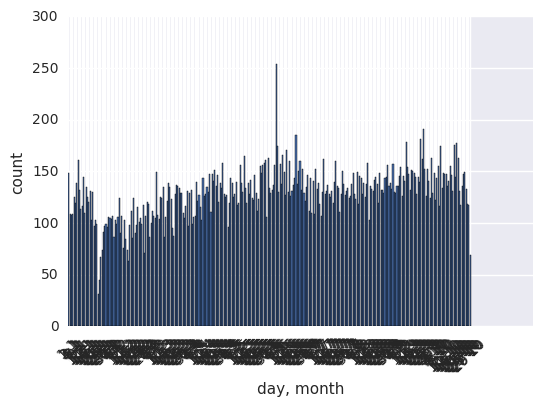

In [107]:
%matplotlib inline
result = _
result.bar()

## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.